# Predicting Insurance Costs With Linear Regression

In this project we are going to train a linear regression model on the Medical Cost Data Set from Kaggle with the intent of predicting total medical cost. 

Below is a breakdown of the columns from the dataset:

`age`: age of primary beneficiary

`sex`: insurance contractor gender, female, male

`bmi`: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

`children`: Number of children covered by health insurance / Number of dependents

`smoker`: Smoking

`region`: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

`charges`: Individual medical costs billed by health insurance

## Overview

In [49]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

insurance = pd.read_csv('insurance.csv')
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


array([[<AxesSubplot:title={'center':'charges'}>]], dtype=object)

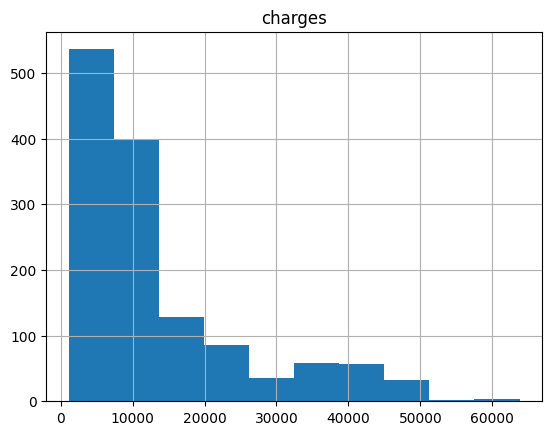

In [50]:
#look at outcome var 
insurance.hist('charges')

Immediately, we observe that our outcome variable is skewed, this makes it unlikey for our errors to be centered at zero (one of our linear regression assumptions). We can transform our outcome variable with a log-transformation, that should reduce the skewness and allow for our model to be more accurate. 

<AxesSubplot:>

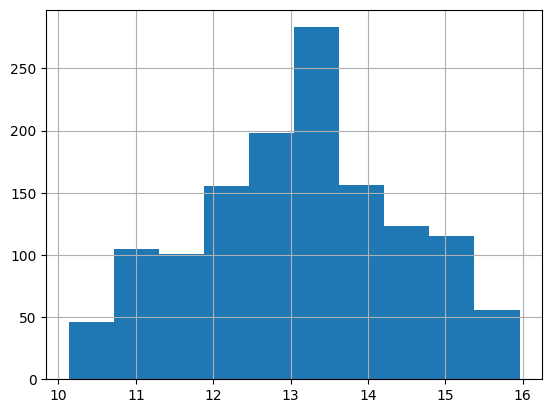

In [51]:
insurance['log_charges'] = np.log2(insurance['charges'])

insurance['log_charges'].hist()

This appears to have done the trick.

In [52]:
#removing charges
insurance.drop('charges', axis=1, inplace=True)

#converting columns to dummies and removing duplicates
insurance = pd.get_dummies(data=insurance, columns=['sex', 'smoker', 'region', 'children'])

In [53]:
insurance.drop(['sex_male','smoker_no'], axis=1, inplace=True) 

In [54]:
insurance.head()

,age,bmi,log_charges,sex_female,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,children_0,children_1,children_2,children_3,children_4,children_5
0,19,27.900,14.043448,1,1,0,0,0,1,1,0,0,0,0,0
1,18,33.770,10.752842,0,0,0,0,1,0,0,1,0,0,0,0
2,28,33.000,12.119415,0,0,0,0,1,0,0,0,0,1,0,0
3,33,22.705,14.424197,0,0,0,1,0,0,1,0,0,0,0,0
4,32,28.880,11.916945,0,0,0,1,0,0,1,0,0,0,0,0


In [56]:
#check corr
insurance.corr().unstack().sort_values(ascending=False).drop_duplicates().head(10)

age               age            1.000000
smoker_yes        log_charges    0.665506
log_charges       age            0.527834
region_southeast  bmi            0.270025
bmi               log_charges    0.132669
age               bmi            0.109272
log_charges       children_3     0.107200
                  children_2     0.101524
region_southeast  smoker_yes     0.068498
children_3        age            0.061263
dtype: float64

The potential predictors that exhibit the highest correlations with outcome variable `log_charges` are: 

* `smoker_yes`

* `age` 

* `children_1`, `children_2`, `children_3`, `children_4`, `children_5` 

* `bmi`

The following correlations between predictors are also worth keeping in mind:

* `bmi` and `reigon_southwest` 

* `bmi` and `age` 

## Feature Selection

We now have to select which features we'd like to include in our linear model. We do this based on a combination of domain knowledge, and observed correlative relationships between the predictors and outcome variable. As such, the four predictors we have chosen are listed: 

`smoker_yes`, `age`, `children`, and `bmi`

Keep in mind this is when we'd normally do our evaluation of the linearity assumption for our model. In this case, for the sake of project flow, we hold off on this until a later section dedicated entirely to assumptions. 

## Preparing The Model

Here we begin the process of preparing our model, starting with breaking up our data into training and testing sets. 

In [57]:
feats = ['smoker_yes', 'age', 'children_1', 'children_2', 'children_3', 'children_4', 'children_5', 'bmi'] 

#sep data for T_T_Split
X = insurance[feats]
y = insurance['log_charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=417)

#standardizing to ensure equal contribution to analysis from predictors
scaler = StandardScaler() #creating instance of StandardScaler class

#fitting/transforming data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Constructing The Model

Now that our features are selected, and our train/test data is prepared, we can finally begin training our model!

In [58]:
#create instance of LinearRegression class 
lr = LinearRegression()

#fit to training data
lr.fit(X_train_scaled, y_train)

#predict
y_pred_train = lr.predict(X_train_scaled)

#look at coeffs
coefs = lr.coef_
print(f'Betas:{coefs}')

Betas:[0.91062863 0.70132833 0.09956005 0.18063666 0.12485332 0.11488767
 0.0520758  0.09446636]


In [59]:
#calc metrics
r2 = r2_score(y_train, y_pred_train)
print(f'R-Squared:{r2.round(4)}')

rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
print(f'RMSE:{rmse.round(4)}')

R-Squared:0.7597
RMSE:0.6548


At first glance, these metrics look promising. But, it is important to remember that these were calculated using only our training data throughout the whole process. The latter means that these results are likely overly optimistic, and thus require further evaluation.

Below is a discussion on the printed metrics:

*R-Squared*: This metric captures the percent of the variation explained by our linear model, i.e. by taking our predictors into account. In our case, this number is rather high, which is a good sign.

*Root Mean Squared Error (RMSE)*: This metric is simply the mean squared error, but in the same terms as the outcome variable. The mean squared error is the average difference between the actual and predicted values squared. This gives us an idea of how close our regression line is to a set of data points, specifically, those associated with our outcome variable. This is not exceptionally high, which is a good sign.

## Evaluating Our Assumptions

The four assumptions for linear regression are as follows: 

1. Linearity: the average outcome must be linearly related to each predictor holding the others fixed. 

2. Normal Distribution of the Errors: The residuals must follow a normal distribution with their mean centered at zero. 

3. No Heteroscedasticity : This describes a situation where the variance of our residuals are not constant -- we do not want this. One can evaluate the latter with a residual plot where the residuals are plotted on the y-axis against our predicted values on the x-axis.  

4. No Multicollinearity: We cannot allow for any 2 predictors in our model to maintain strong correlations with each-other. The latter situation makes it difficult to reliably calculate our coefficients. We can evaluate this by looking at a correlation matrix.

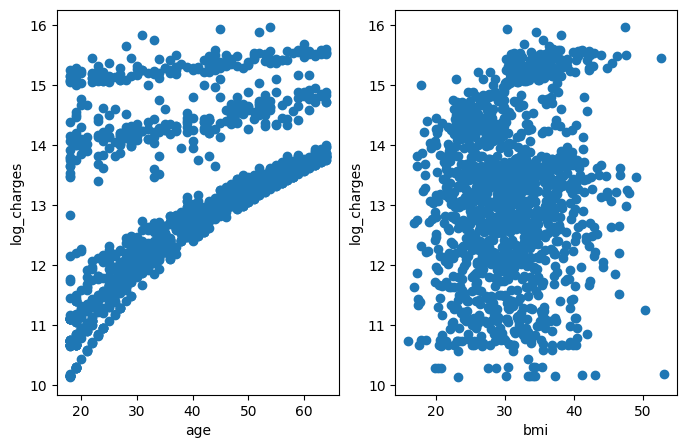

In [72]:
#linearity

#note: normally we'd evaluate this earlier, but we wanted to keep all the assumptions in one place for the sake of the project's organization

fig = plt.figure(figsize=(8,5))

fig.add_subplot(121)
plt.scatter(data=insurance, x='age', y='log_charges')
plt.xlabel('age')
plt.ylabel('log_charges')

fig.add_subplot(122)
plt.scatter(data=insurance, x='bmi', y='log_charges')
plt.xlabel('bmi')
plt.ylabel('log_charges')

plt.show()

From these two charts we can make the following observations: 

The relationship between `age` and `log_charges` appears to be linear. 

The relationship between `bmi` and `log_charges` appears to be non-existant. We will still include this in our model, but must keep the aformentioned in mind moving forward. 

Also, worth, noting is the lack of scatterplots for our categorical variables. Firstly, to clarify, the linearity assumption states that the condition is linearity for each term in the model. Thus, for a binary predictor the linearity assumption is automatically true -- there exist only two means, one for each level of the predictor (i.e. each term in the model), and these two points will always create a straight line. The same logic can be extended to categorical variables, like `children`. One can plot the mean outcome vs each individual level, or "term in the model", and we are left with the same situation as with dummy variables.

In [73]:
#next assumptions...

#first calculate residuals
residuals = y_train - y_pred_train

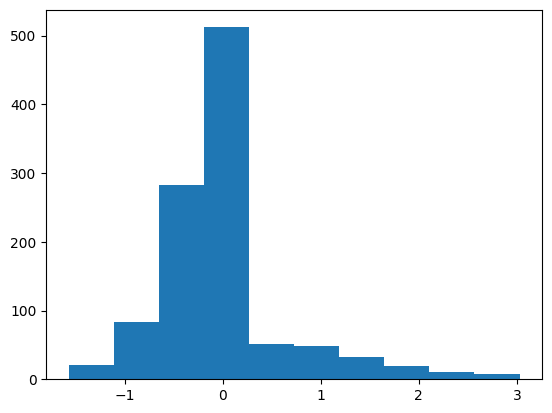

-6.341759931316782e-16


In [74]:
#Normal distribution of errors -- histogram of residuals

plt.hist(residuals)
plt.show()

print(residuals.mean())

It does not appear that our residuals are perfectly normally distributed, but the mean appears to be close to zero, so we will continue with our analysis. 

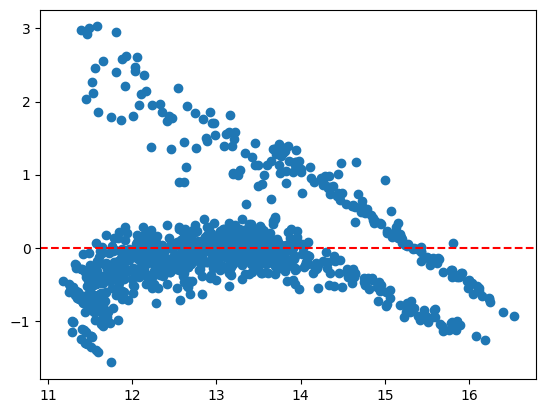

In [75]:
#Homosked -- creating residual plot to evaluate if variance of residuals constant

#plot residuals against predicted
plt.scatter(x=y_pred_train, y=residuals)
plt.axhline(0, linestyle='--', color='r')
plt.show()

The variation in our residuals does not appear to be constant, notice the 'fanning-out' of the residuals into a triangular shape. The latter is evidence of Heteroscedasticity, and technically violates our third assumption. The OLS estimators within our model are likely compromised, and thus so is our predictive accuracy. Nonetheless, we will push on with our analysis. 

In [76]:
#multicollinearity

insurance[feats].corr()

,smoker_yes,age,children_1,children_2,children_3,children_4,children_5,bmi
smoker_yes,1.000000,-0.025019,-0.023129,0.028249,0.039415,-0.028991,-0.043183,0.003750
age,-0.025019,1.000000,0.009928,0.007950,0.061263,-0.002034,-0.029898,0.109272
children_1,-0.023129,0.009928,1.000000,-0.264276,-0.206100,-0.077999,-0.066009,-0.003732
children_2,0.028249,0.007950,-0.264276,1.000000,-0.170463,-0.064512,-0.054595,0.024136
children_3,0.039415,0.061263,-0.206100,-0.170463,1.000000,-0.050311,-0.042577,0.001252
children_4,-0.028991,-0.002034,-0.077999,-0.064512,-0.050311,1.000000,-0.016113,0.016475
children_5,-0.043183,-0.029898,-0.066009,-0.054595,-0.042577,-0.016113,1.000000,-0.020275
bmi,0.003750,0.109272,-0.003732,0.024136,0.001252,0.016475,-0.020275,1.000000


It appears as though some of the dummies representing the number of children covered by health insurance are correlated, but nothing strongly -- we can proceed.

## Interpretation

Now that the assumptions have been discussed, we can conduct a preliminary interpretation of our model.

In [78]:
#get intercept
intercept = lr.intercept_
print(f'Intercept:{intercept.round(4)}')

Intercept:13.1145


Conventionally, the intercept of a linear regression model is interpreted as the predicted outcome when all the predictors equal zero. Since someone cannot have a zero bmi, or be zero years old, this intercept has no meaningful interpretation. 

In [82]:
for i, value in enumerate(coefs):
    
    print(f'Beta_{i}: {value.round(4)}\n')

Beta_0: 0.9106

Beta_1: 0.7013

Beta_2: 0.0996

Beta_3: 0.1806

Beta_4: 0.1249

Beta_5: 0.1149

Beta_6: 0.0521

Beta_7: 0.0945



Despite the partially violated assumptions from earlier, for the sake of edification, we will still go over what some of the coefficients mean in the regression.

Beta_0: This term is associated with the dummy variable of one's status as a smoker. It's interpretation is the average difference in outcome between those in level 1 and level 0 of the dummy variable, holding all other predictors constant. Specifically, being a smoker is associated with a 90% increase in log charges, holding bmi, age, and number of dependents constant.

Beta_1: This term is associated with the continuous variable capturing one's age. It's interpretation is, a 1 unit increase in age is associated with a 70% increase in the log charges, holding other factors constant. 

## Final Evaluation

Now it's time to evaluate our model on our testing data. 

In [86]:
#produce predictions with test data
y_pred_test = lr.predict(X_test_scaled)

#calc RMSE
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f'Final RMSE: {rmse_final.round(4)}')

Final RMSE: 0.6028


This value is lower than before, which is a good thing. The above can be interpreted as the average difference in log charges between the predicted values from our model and the actual values in our dataset. 

## Conclusion

Despite our model not entirely living up to what we might have wished, it appears that we were able to generate a moderately useful predictive model for total medical costs. 

The relative effects from each of the predictors lines up with what one might have anticipated, that being that increases in age and one's status as a smoker predict higher total medical bills per-individual. 

As far as an insurance company being able to employ our model, considering its violation of some of the assumptions required for linear regression, it's likely that the predictive abilities of the model have been in some way comprimised. This represents a potential liability for a firm attempting to employ a model in a predictive capacity such that those predictions might assist them in reducing their bottom line.

Finally, there exists an opportunity to collect more data and apply more sophisticated techniques to combat some of the issues we encountered with this model. In this way, one might be able to construct something worthy of deployment in an institutional setting. 